# Calculate uncertainties in geodetic mass balance

## A brief introduction

The method is based on Hugonnet et al. (2022) and assess the uncertainty at 1-sigma level from the spatial correlation and the heteroscedacity of elevation change.

Hereafter, we follow three tutorials:
- assessing the spatial correlation: https://xdem.readthedocs.io/en/latest/basic_examples/plot_infer_spatial_correlation.html
- assessing the heteroscedasticity of the data: https://xdem.readthedocs.io/en/latest/advanced_examples/plot_heterosc_estimation_modelling.html
- propagating the uncertainty: https://xdem.readthedocs.io/en/latest/basic_examples/plot_spatial_error_propagation.html
    
## Load the relevant packages

In [1]:
import geoutils as gu
import xdem
import numpy as np
import matplotlib.pyplot as plt

## Load the relevant data

In [2]:
path = '/Users/adehecq/work/south_col_glacier/data/'

dh_map = path + '1984_2017_dh_WesternCwm_2m.tif'
shp_gla = path + 'GAMDAM_Everest_sub.shp'
ref_DEM_file = path + 'Khumbu_2017-03-23_DEM_4m.tif'

dh = xdem.DEM(dh_map)
ref_dem = xdem.DEM(ref_DEM_file)
glacier_outlines = gu.Vector(shp_gla)


## Make sure all datasets are in the same proj and grid

In [3]:
dh = dh.reproject(ref_dem, silent=True)

In [4]:
glacier_outlines = gu.Vector(glacier_outlines.ds.to_crs(dh.crs))

## Optional: plot the dh map and DEM

(3083354.0, 3101266.0)

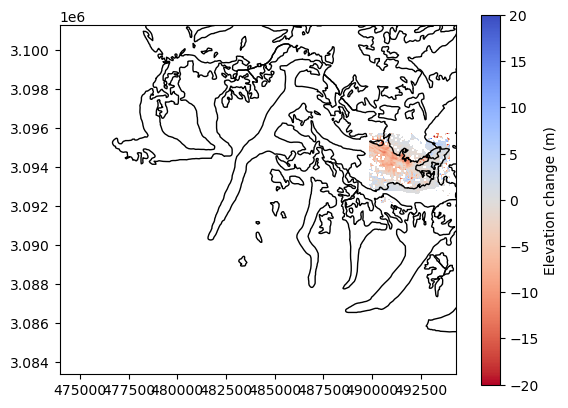

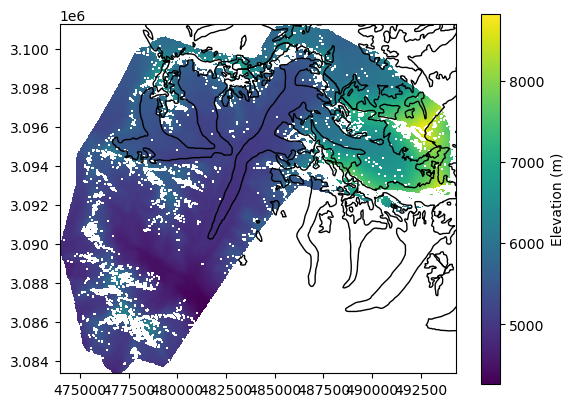

In [5]:
plt.figure()
ax = plt.subplot(111)
dh.show(ax=ax,cmap='coolwarm_r', vmin=-20, vmax=20, cb_title="Elevation change (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

plt.figure()
ax = plt.subplot(111)
ref_dem.show(ax=ax,cmap='viridis', cb_title="Elevation (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

## Empirical variogram and plot
Increase the default subsample size (default 1000) and draw 5 variograms, to make results more reliable

In [6]:
df_empirical_variogram, df_model_params, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh, list_models=["Spherical", "Spherical"], unstable_mask=glacier_outlines, subsample=4000, n_variograms=5, n_jobs=4
)

print("Model parameters:")
print(f"Model 1: range = { df_model_params.iloc[0].range:.2f} m, sill = {df_model_params.iloc[0].psill:.2f} m^2")
print(f"Model 2: range = { df_model_params.iloc[1].range:.2f} m, sill = {df_model_params.iloc[1].psill:.2f} m^2")

/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model parameters:
Model 1: range = 84.73 m, sill = 7.51 m^2
Model 2: range = 7141.26 m, sill = 0.84 m^2


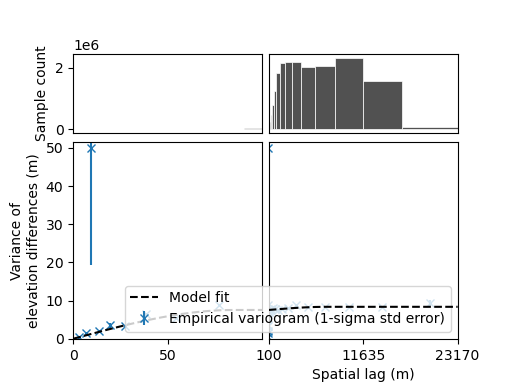

In [7]:
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m)",
    xscale_range_split=[100,],
)

## Estimate heteroscedasticity

In [8]:
slope, max_curv = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh, list_var=[slope, max_curv], list_var_names=["slope", "maxc"], unstable_mask=glacier_outlines
)

zscores = dh / errors
# emp_variogram, params_variogram_model, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
#     dvalues=zscores, list_models=["Gaussian", "Spherical"], unstable_mask=glacier_outlines, random_state=42
# )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/adehecq/development/GlacioHack/xdem/xdem/terrain.py:996: RuntimeWarning: invalid value encountered in true_divide
  -2
/Users/adehecq/development/GlacioHack/xdem/xdem/terrain.py:1026: RuntimeWarning: invalid value encountered in true_divide
  2


## Show dependency of error with slope and curvature

First extract only valid pixels outside glaciers 

In [9]:
glacier_mask = glacier_outlines.create_mask(dh).squeeze()
valid_mask = ~gu.spatial_tools.get_mask(dh.data) & ~gu.spatial_tools.get_mask(slope.data)
dh_arr = dh.data[0][~glacier_mask & valid_mask]
slope_arr = slope.data[0][~glacier_mask & valid_mask]
max_curv_arr = max_curv.data[0][~glacier_mask & valid_mask]

Bin elevation error as a function of slope and maximum curvature

In [10]:
slope_bins = np.arange(0, 90, 5)
max_curv_bins = np.nanquantile(max_curv_arr, np.linspace(0.02, 0.98, 100))

df = xdem.spatialstats.nd_binning(
    values=dh_arr,
    list_var=[slope_arr, max_curv_arr],
    list_var_names=["slope", "maxc"],
    statistics=["count", xdem.spatialstats.nmad],
    list_var_bins=[slope_bins, max_curv_bins],
)

/usr/local/Caskroom/miniconda/base/envs/xdem/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Plot error as a function of slope

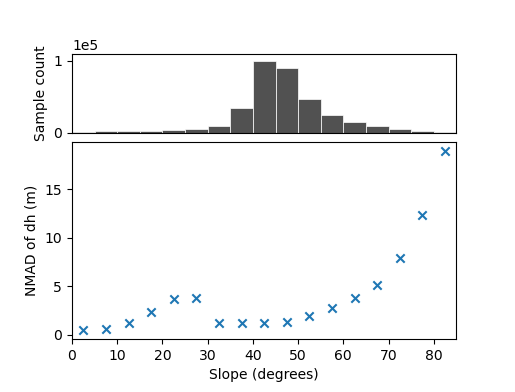

In [11]:
xdem.spatialstats.plot_1d_binning(
    df, var_name="slope", statistic_name="nmad", label_var="Slope (degrees)", label_statistic="NMAD of dh (m)"
)

Plot error as a function of maximum curvature

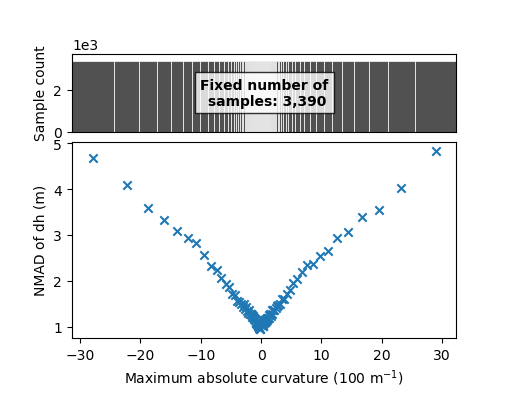

In [12]:
xdem.spatialstats.plot_1d_binning(
    df, var_name="maxc", statistic_name="nmad", label_var="Maximum absolute curvature (100 m$^{-1}$)", label_statistic="NMAD of dh (m)"
)

Plot error as a function of both

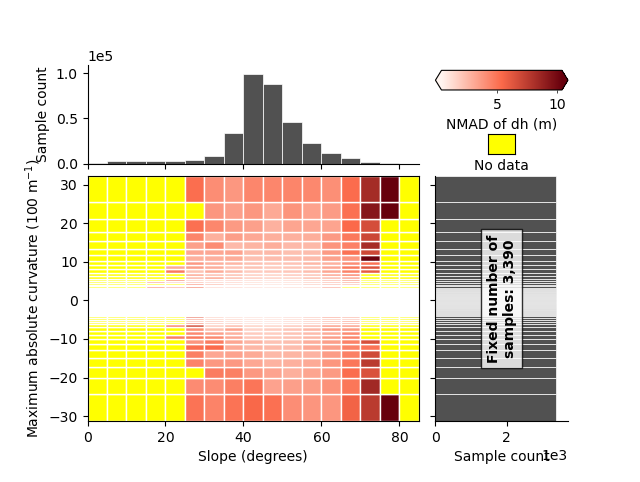

In [13]:
xdem.spatialstats.plot_2d_binning(
    df,
    var_name_1="slope",
    var_name_2="maxc",
    statistic_name="nmad",
    label_var_name_1="Slope (degrees)",
    label_var_name_2="Maximum absolute curvature (100 m$^{-1}$)",
    label_statistic="NMAD of dh (m)",
)

## Spatial integration of variance on the target area

In [14]:
# areas = [glacier_outlines.ds[glacier_outlines.ds["NAME"] == "SCG"]]
areas = [glacier_outlines.ds[glacier_outlines.ds["FID_1"] == 3643]]

stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=df_model_params
)

for glacier_name, stderr_gla in [("SCG", stderr_glaciers[0])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for SCG is 0.61 meters.
